#### Project requirements: Compare if two digits are the same
#### Project goal: accuracy on test > 95%

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import random
import tensorflow.compat.v1 as tf
from tensorflow.keras.datasets.mnist import load_data
from sklearn.preprocessing import StandardScaler

In [2]:
import random
def reset_graph():
    tf.reset_default_graph()
    seed = random.randint(1, 500)
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [3]:
reset_graph()

In [4]:
(X_train, y_train), (X_test, y_test) = load_data()

In [5]:
def reshape_data(X):
    return X.reshape(X.shape[0], -1)

In [6]:
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

In [7]:
X_train = reshape_data(X_train)
X_test = reshape_data(X_test)

In [8]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [9]:
def scale(x):
    if x != 0:
        return 1
    else:
        return 0

In [10]:
vscale = np.vectorize(scale)

In [11]:
X_train = vscale(X_train)
X_test = vscale(X_test)

#### random data visualization

In [12]:
batch_size = 5
X_batch, y_batch = generate_batch(X_train, y_train, batch_size)

In [13]:
X_batch.shape, X_batch.dtype

((5, 2, 784), dtype('int64'))

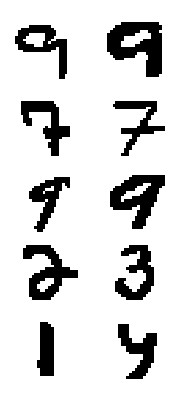

In [14]:
plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

In [15]:
y_batch

array([[1],
       [1],
       [1],
       [0],
       [0]])

#### First three rows (digits) are the same ("ones") but last two are diffrent ("zeros")

#### Train model

In [16]:
he_init = tf.keras.initializers.VarianceScaling()
n_inputs = 28 * 28 # zbiór MNIST
learning_rate = 0.01
momentum = 0.92
n_epochs = 151
batch_size = 1500
X_test, y_test = generate_batch(X_test, y_test, batch_size=len(X_test))

In [17]:
def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None, activation=tf.nn.elu, initializer=he_init):
    with tf.variable_scope(name, "dnn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
                                     kernel_initializer=initializer,
                                     name="hidden%d" % (layer + 1))
        return inputs

In [18]:
with tf.Session() as sess:
    X = tf.placeholder(tf.float32, shape=(None, 2, n_inputs), name="X")
    X1, X2 = tf.unstack(X, axis=1)
    y = tf.placeholder(tf.int32, shape=[None, 1])
    dnn1 = dnn(X1, name="DNN_A")
    dnn2 = dnn(X2, name="DNN_B")
    dnn_outputs = tf.concat([dnn1, dnn2], axis = 1)
    hidden = tf.layers.dense(dnn_outputs, units = 10, activation=tf.nn.elu, kernel_initializer=he_init)
    logits = tf.layers.dense(hidden, units = 1, kernel_initializer=he_init)
    # y_proba = tf.nn.sigmoid(logits)
    y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32) # Equal to p_proba >= 0.5
    y_as_float = tf.cast(y, tf.float32)
    xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
    loss = tf.reduce_mean(xentropy) 
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
    training_op = optimizer.minimize(loss)
    y_pred_correct = tf.equal(y_pred, y)
    accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(X_train) // batch_size):
            X_batch, y_batch = generate_batch(X_train, y_train, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print('*Test*', 'epoch:', epoch, 'accuracy:', acc_test, 'loss:', loss_val)
    save_path = saver.save(sess, "./model.ckpt")

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
*Test* epoch: 0 accuracy: 0.4991 loss: 0.6936644
*Test* epoch: 10 accuracy: 0.7722 loss: 0.50140333
*Test* epoch: 20 accuracy: 0.8468 loss: 0.36936772
*Test* epoch: 30 accuracy: 0.8914 loss: 0.28948665
*Test* epoch: 40 accuracy: 0.9113 loss: 0.24010034
*Test* epoch: 50 accuracy: 0.924 loss: 0.1895744
*Test* epoch: 60 accuracy: 0.9373 loss: 0.17167248
*Test* epoch: 70 accuracy: 0.9428 loss: 0.12680458
*Test* epoch: 80 accuracy: 0.9492 loss: 0.11247782
*Test* epoch: 90 accuracy: 0.9535 loss: 0.09718114
*Test* epoch: 100 accuracy: 0.9563 loss: 0.115926564
*Test* epoch: 110 accuracy: 0.96 loss: 0.10598052
*Test* epoch: 120 accuracy: 0.9589 loss: 0.08233658
*Test* epoch: 130 accuracy: 0.9628 loss: 0.08710274
*Test* epoch: 140 accuracy: 0.9638 loss: 0.08637983
*Test* epoch: 150 accuracy: 0.9664 loss: 0.068575285


#### Accuracy: ~96.6%